# Importing libraries for exploratory data analysis, and the dataset for red wines

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.max_columns', 24)
df = pd.read_csv('datasets/wine_quality_white.csv')
df['quality_label']=df['quality'].apply(lambda x: 'low' if x<=5 else 'medium' if x<=7 else 'high')

In [2]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality quality_label  
0      8.8        6        medium  
1      9.5        6        medium  
2     10.1        6        medium  
3      9.9        6        medium  
4      9.9        6        medium

# selecting continuos features for predictions

In [3]:
attributes = df.columns[:-2]


In [4]:
df.quality_label.value_counts()

medium    3078
low       1640
high       180
Name: quality_label, dtype: int64

# running tukey highest significance difference on features to locate statistically significant features of wine, and ploting the results
* p values and alpha are inversed, therefore, pairs in which features with $p^{-1}$ values greater than 20$(0.05^{-1})$ are statistically significant within a confindence level 0f 95%

In [5]:
tukey_results = {}
for attribute in attributes:
    tukey_results[attribute]=pairwise_tukeyhsd(df[attribute],df['quality_label'],0.05)

In [6]:
tukey_df = pd.DataFrame(columns = ['pair','meandiff', 'inv_p_val','feature'])
for key,val in tukey_results.items():
    data = {'pair':['low-high', 'medium-high', 'medium-low'],
        'meandiff':val.meandiffs,
        'inv_p_val':val.pvalues**(-1),
        'feature':[key,key,key]}
    local_data = pd.DataFrame.from_dict(data)
    # display(tukey_df)
    tukey_df = tukey_df.append(local_data, ignore_index = True)

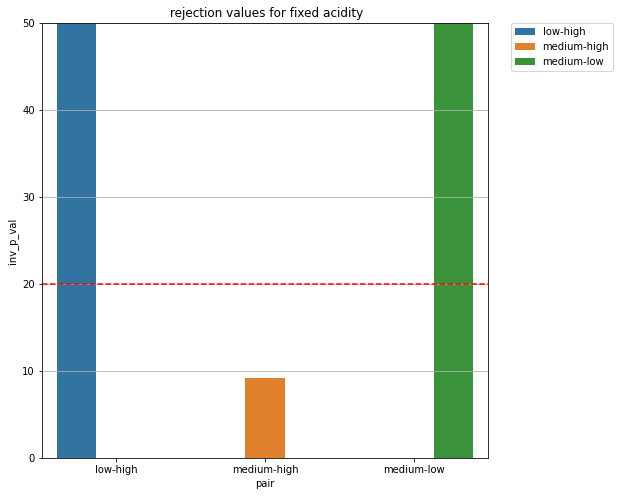

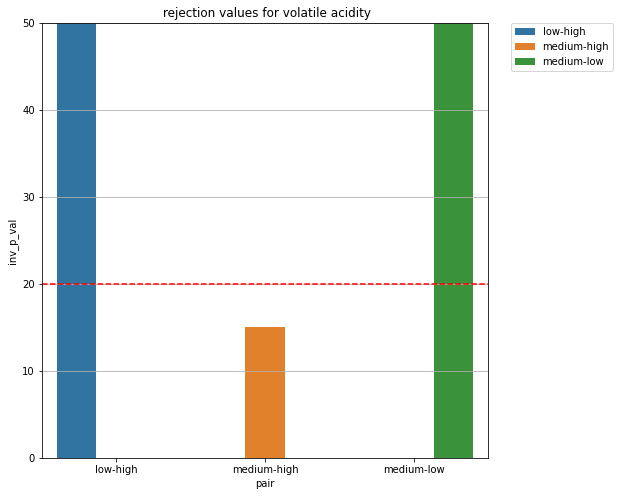

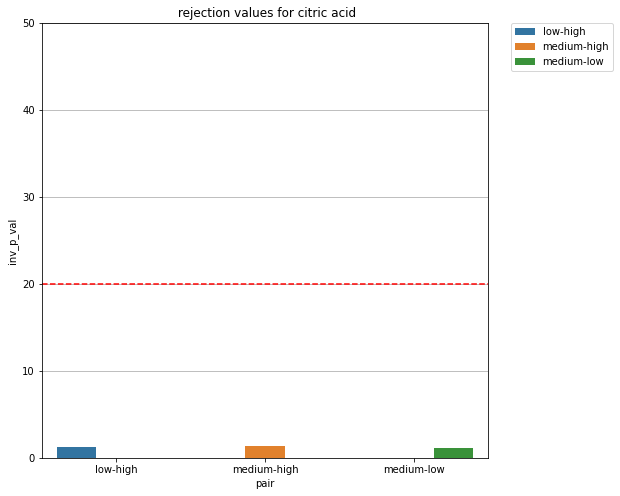

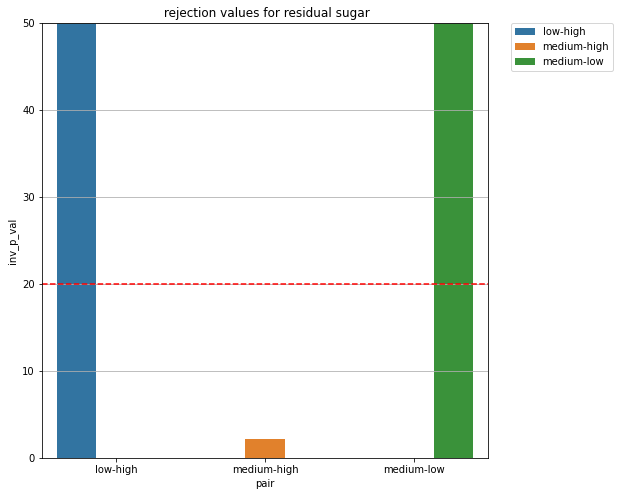

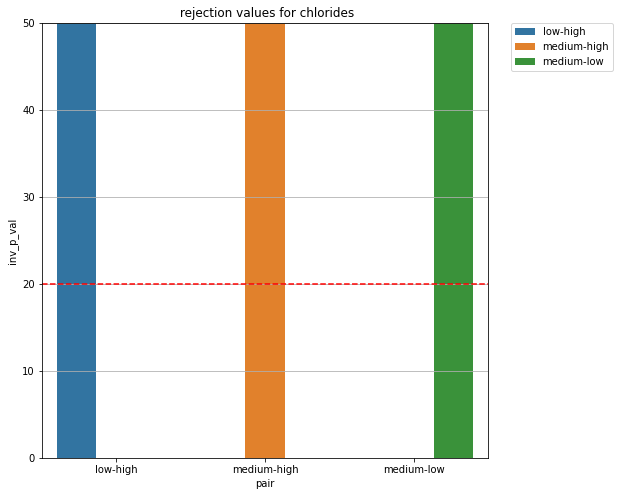

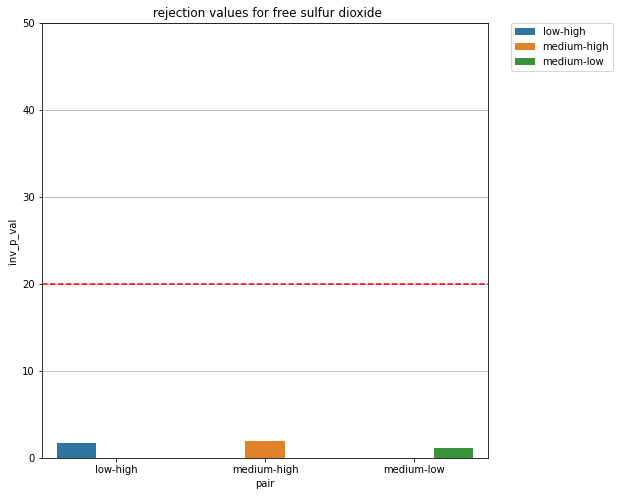

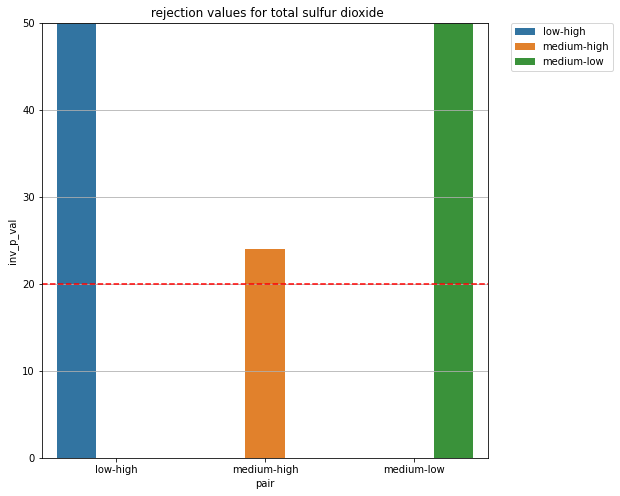

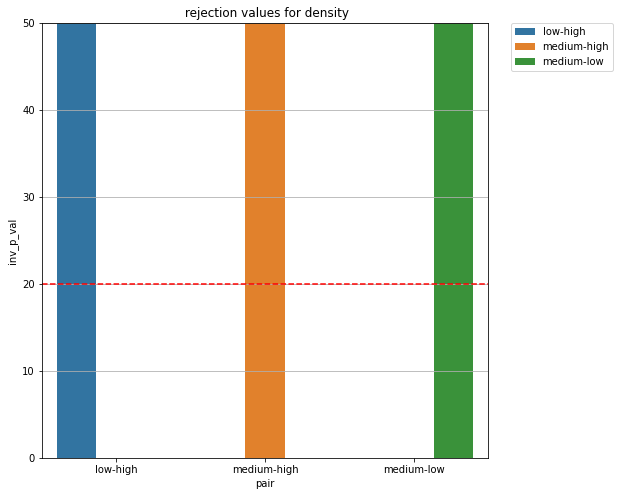

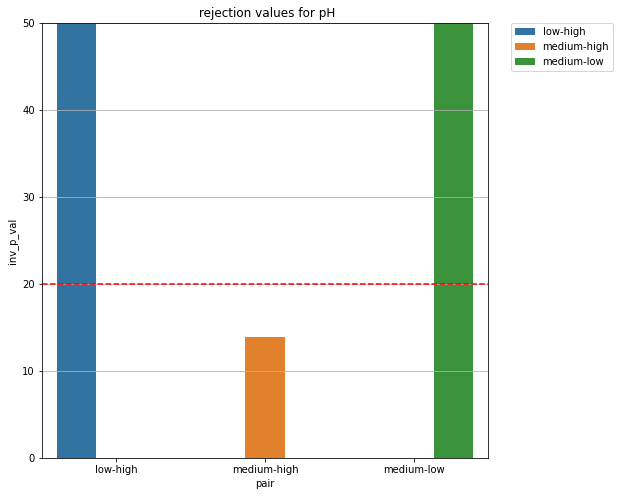

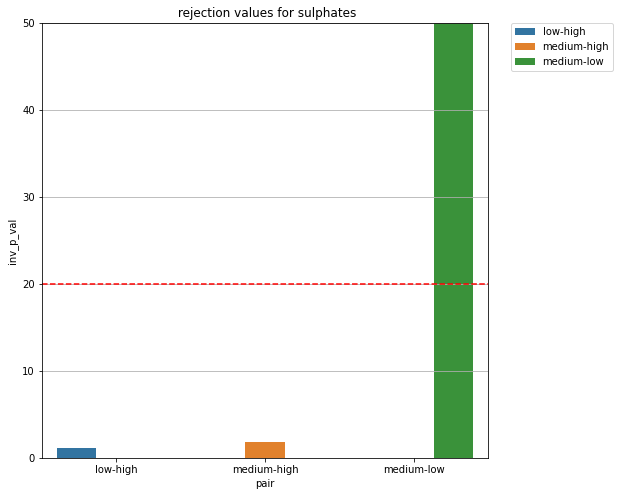

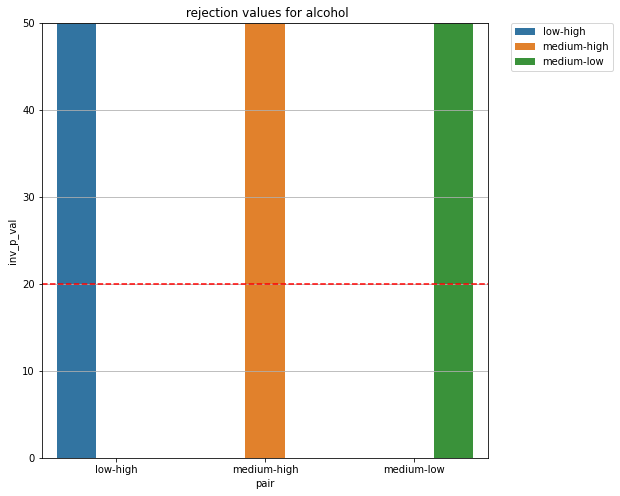

In [7]:
for ind,feature in enumerate(attributes):
    local_df= tukey_df[tukey_df['feature'] == feature]
    fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (8,8))
    fig.patch.set_facecolor('white')
    sns.barplot(data = local_df,x='pair',y='inv_p_val', hue='pair', ax = ax)
    ax.set_ylim(0,50)
    ax.axhline(y = 0.05**(-1), c = 'r', linestyle = '--')
    tit =f' rejection values for {feature}'
    ax.set_title(tit)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(b=True, which='both', axis='y')
    # plt.savefig(f'plots/white/rejection value forquality labels by {feature}.png')

# Using boxplots to visualize the IQR 25%-75% of different features

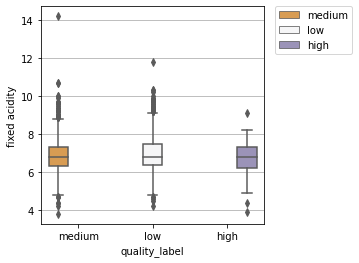

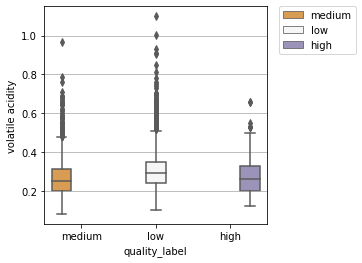

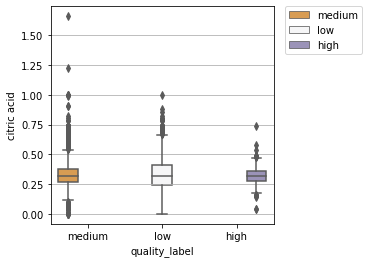

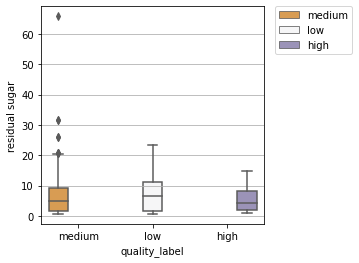

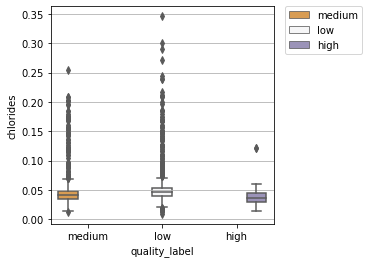

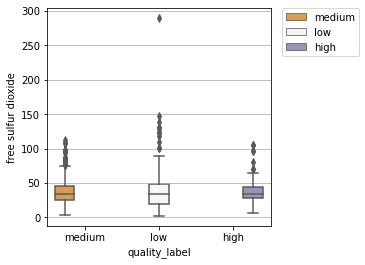

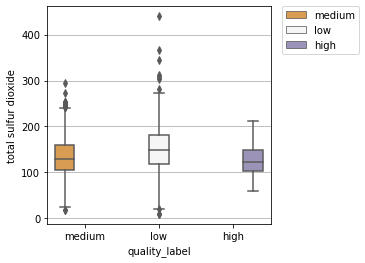

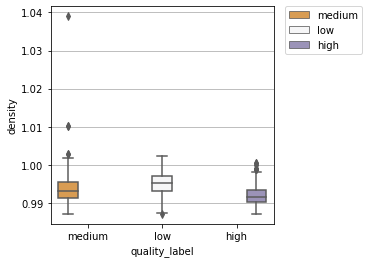

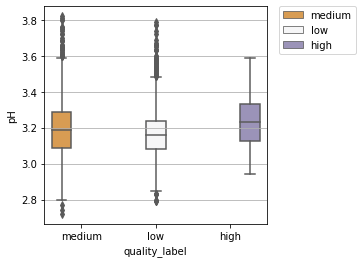

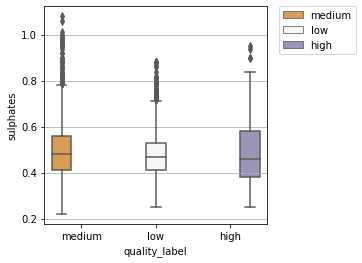

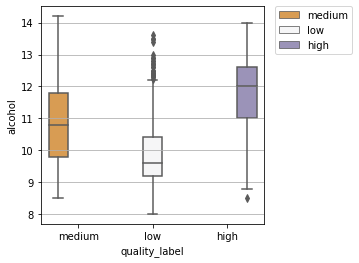

In [8]:
for ind,feature in enumerate(attributes):
    fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))
    fig.patch.set_facecolor('white')
    sns.boxplot(data = df,x='quality_label',y=f'{feature}', hue='quality_label',palette = 'PuOr', ax = ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(b=True, which='both', axis='y')
    # plt.savefig(f'plots/white/{feature}_by_quality_label.png')

# using histograms to visualize distributions of datapoints in features

/usr/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


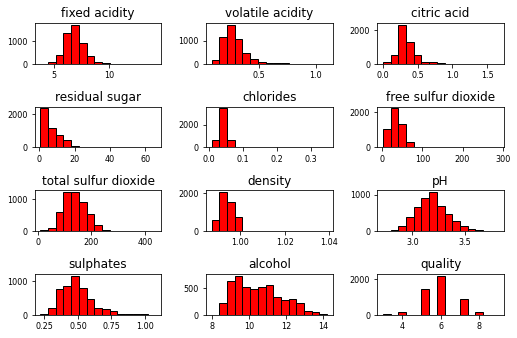

In [9]:
df.hist(bins=15, color='red', edgecolor='black', linewidth=1.0,
xlabelsize=8, ylabelsize=8, grid=False)

plt.tight_layout(rect=(0, 0, 1.2, 1.2))

# EDA Summary:
* except for free sulfur dioxide and citric acid, all other features have statistically significant difference between at least one of the 3 quality wine_labels
* The following features have approximately normal distribution of values: fixed acidity, chlorides ph.
* the following feature are sqewed towards higher values: volatile acidity, residual sugars,free sulfur dioxide, total sulfur dioxide, density,  sulphates, alcohol

# Selecting classification models:
* different models would be compared using different sampling methods and scaling methods, the goal is to select a method with low bias towards each quality label - a model in which the f1 scores for each model are the closest to the average f1 score.

In [10]:
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [11]:
label_quality = LabelEncoder()

In [12]:
df['quality_label']=label_quality.fit_transform(df.quality_label)

* create_models_comparisons is comparing the selcted models in a given sampler and scaler, and summarizing the classification reports from each model in a table to be visualized.

In [13]:
def create_model_report(model,X,y, pipeline = False, sampler = None, scaler = None):
    """
    assumes
        model is sklearn predictor
        model_name str representation of model
        X is training data
        y, target values
        pipeline bool
        sampler sampler object (SMOTE,under_sampler,etc...)
        scaler scikit scaler
    return
        list of values - ['precision_low', 'recall_low', 'f1-score_low', 'support_low','precision_medium','recall_medium', 'f1-score_medium', 'support_medium','precision_high', 'recall_high', 'f1-score_high', 'support_high','accuracy']
    """
    def reporting(model_name, report):
        """
        assumes
            report dict classification report
        returns
            list of values from classification report
        """
        l = [model_name]
        for key, item in report.items():
            if key == 'accuracy':
                l.append(round(item,3))
            else:
                for k,value in item.items():
                    l.append(round(value,3))
        return l
    model_name = model[0]
    model_obj = model[1]
    wine_labels = list(df.quality_label.unique())
    if pipeline:
        X_samp,y_samp = sampler.fit_resample(X,y)
        X_scaled = scaler.fit_transform(X_samp)
        X_train,X_test, y_train,y_test = train_test_split(X_scaled, y_samp, test_size = 0.2, random_state=42)
        model_obj.fit(X_train,y_train)
        report = classification_report(y_test, model_obj.predict(X_test), labels = wine_labels, output_dict = True)
        return reporting(model_name, report)
    else:
            
        X_train,X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
        model_obj.fit(X_train,y_train)
        report = classification_report(y_test, model_obj.predict(X_test), labels = wine_labels, output_dict = True)
        return reporting(model_name, report)

In [14]:
def create_models_comparison(scaler, models, model_names, sampler = None):
    """
    assumes:
        scaler a scikit learn scaler object
        models list of scikit-learn estimators
        model_names list of string corresponding to models
        sampler a sampler object default None
    returns:
        pandas DataFrame object
    """
    models_tup = []
    reports = []
    for i in range(len(models)):
        models_tup.append((model_names[i],models[i]))
    cols = ['model_name','precision_low', 'recall_low', 'f1-score_low', 'support_low','precision_medium','recall_medium', 'f1-score_medium', 'support_medium','precision_high', 'recall_high', 'f1-score_high', 'support_high','accuracy','mac_avg_precision','mac_avg_recall','mac_avg_f1-score','mac_avg_support','w_avg_precision','w_avg_recall','w_avg_f1-score','w_avg_support']
    if sampler:
        X=df.drop(['quality','quality_label'],axis =1,inplace = False).to_numpy()
        y=df['quality_label'].to_numpy()
        for model in models_tup:
            reports.append(create_model_report(model,X,y, pipeline = True, sampler=sampler, scaler=scaler))
    else:
        df_scaled = scaler.fit_transform(df)
        X=df_scaled[:,:11]
        y=df['quality_label'].to_numpy()
        for model in models_tup:
            reports.append(create_model_report(model,X,y))
    return pd.DataFrame(reports,columns = cols )
        
        

In [15]:
models = [RandomForestClassifier(),LogisticRegression(),LinearSVC(), SVC(),GaussianNB()]
models_names = ['RandomForestClassifier','LogisticRegression','LinearSVC', 'SVC','KNeighborsClassifier','GaussianNB']

# Comparing models with Standard scaler and no sampling

In [16]:
models_report_StnSc = create_models_comparison(StandardScaler(),models,models_names)
models_report_StnSc

/usr/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sam

model_name  precision_low  recall_low  f1-score_low  \
0  RandomForestClassifier          0.841       0.889         0.864   
1      LogisticRegression          0.733       0.867         0.794   
2               LinearSVC          0.730       0.877         0.797   
3                     SVC          0.760       0.867         0.810   
4    KNeighborsClassifier          0.737       0.747         0.742   

   support_low  precision_medium  recall_medium  f1-score_medium  \
0          624             0.779          0.735            0.756   
1          624             0.656          0.492            0.562   
2          624             0.667          0.480            0.558   
3          624             0.690          0.576            0.628   
4          624             0.556          0.573            0.564   

   support_medium  precision_high  recall_high  f1-score_high  support_high  \
0             321           0.824        0.400          0.538            35   
1             321           0.000        0.000          0.000            35   
2             321           0.000        0.000          0.000            35   
3             321           0.000        0.000          0.000            35   
4             321           0.176        0.086          0.115            35   

   accuracy  mac_avg_precision  mac_avg_recall  mac_avg_f1-score  \
0     0.821              0.814           0.675             0.720   
1     0.713              0.463           0.453             0.452   
2     0.715              0.466           0.452             0.452   
3     0.741              0.483           0.481             0.479   
4     0.666              0.490           0.469             0.474   

   mac_avg_support  w_avg_precision  w_avg_recall  w_avg_f1-score  \
0              980            0.820         0.821           0.817   
1              980            0.682         0.713           0.690   
2              980            0.683         0.715           0.690   
3              980            0.710         0.741           0.721   
4              980            0.658         0.666           0.661   

   w_avg_support  
0            980  
1            980  
2            980  
3            980  
4            980

<ipython-input-17-0213797bdf3c>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))


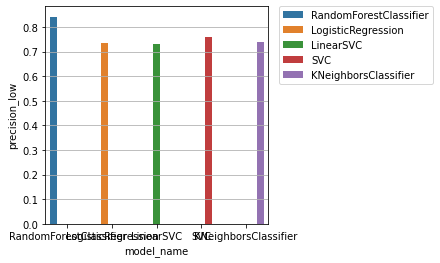

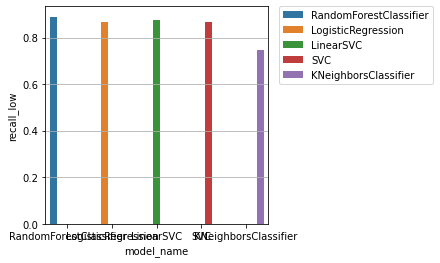

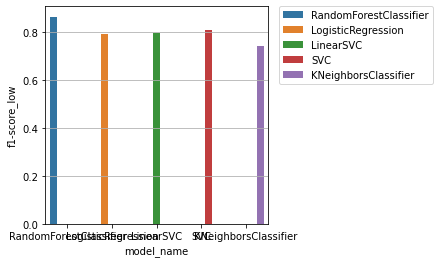

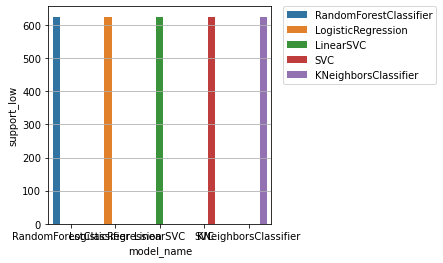

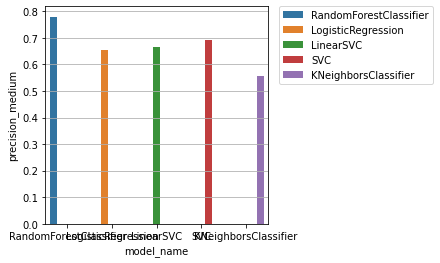

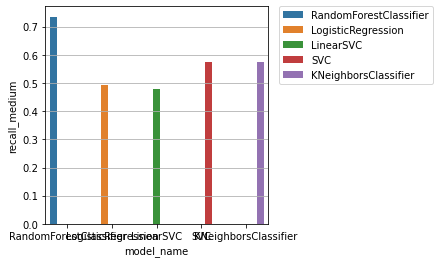

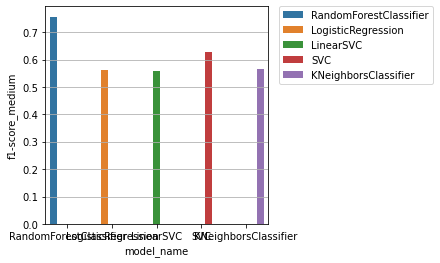

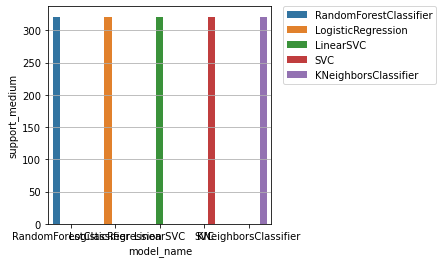

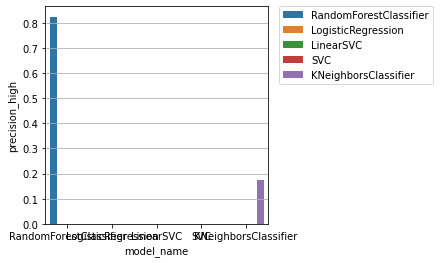

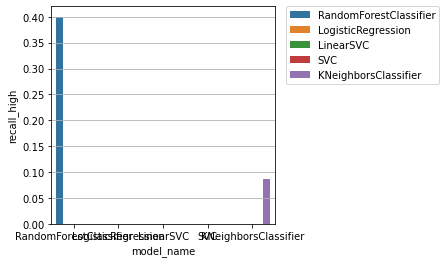

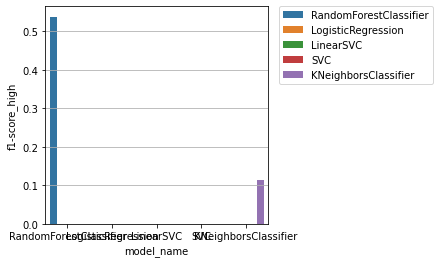

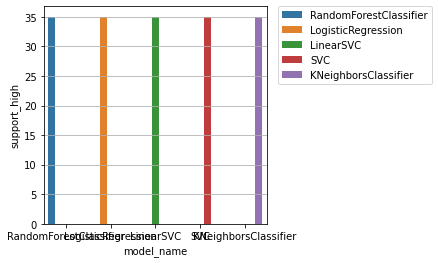

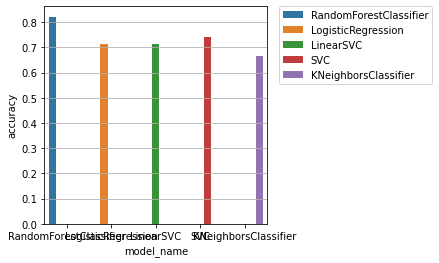

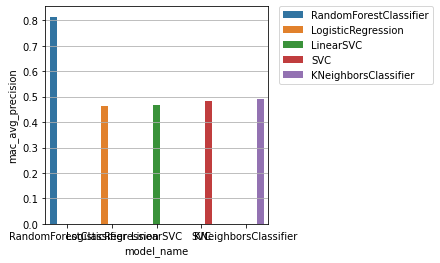

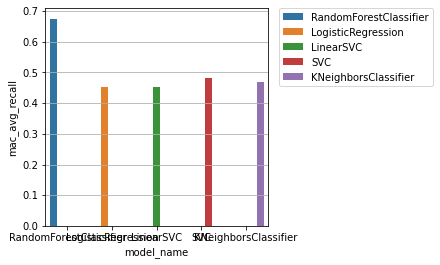

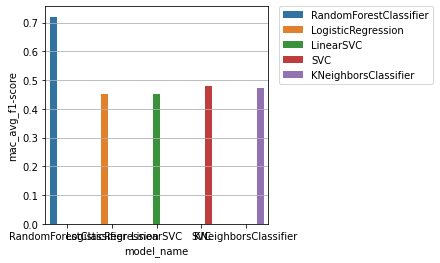

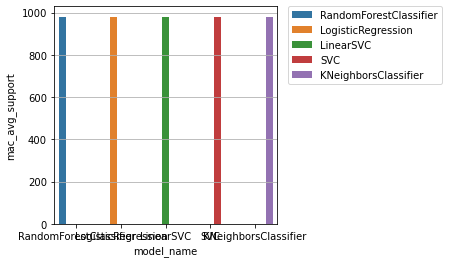

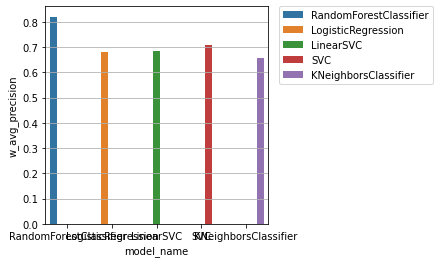

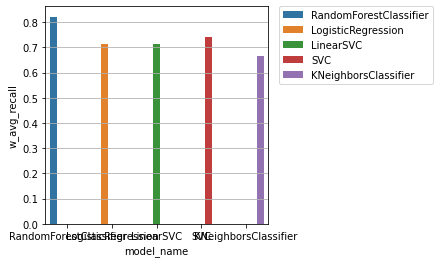

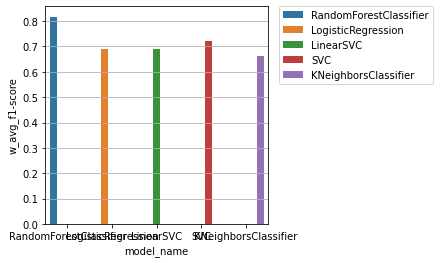

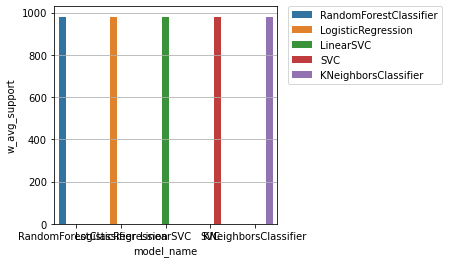

In [17]:
benchmarks = models_report_StnSc.columns[1:]
for ind,benchmark in enumerate(benchmarks):
    fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))
    fig.patch.set_facecolor('white')
    sns.barplot(data = models_report_StnSc,x='model_name',y=f'{benchmark}', hue='model_name', ax = ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(b=True, which='both', axis='y')
    # plt.savefig(f'plots/{benchmark}_by_quality_label.png')

# Comparing models with random undersampling and MinMaxScaler

In [18]:
models_report_under = create_models_comparison(MinMaxScaler(),models,models_names, sampler = RandomUnderSampler(random_state = 42))
models_report_under

model_name  precision_low  recall_low  f1-score_low  \
0  RandomForestClassifier          0.548       0.515         0.531   
1      LogisticRegression          0.440       0.333         0.379   
2               LinearSVC          0.400       0.182         0.250   
3                     SVC          0.467       0.424         0.444   
4    KNeighborsClassifier          0.364       0.242         0.291   

   support_low  precision_medium  recall_medium  f1-score_medium  \
0           33             0.688          0.733            0.710   
1           33             0.575          0.767            0.657   
2           33             0.556          0.833            0.667   
3           33             0.733          0.733            0.733   
4           33             0.571          0.667            0.615   

   support_medium  precision_high  recall_high  f1-score_high  support_high  \
0              30           0.756        0.756          0.756            45   
1              30           0.628        0.600          0.614            45   
2              30           0.562        0.600          0.581            45   
3              30           0.688        0.733          0.710            45   
4              30           0.529        0.600          0.562            45   

   accuracy  mac_avg_precision  mac_avg_recall  mac_avg_f1-score  \
0     0.676              0.664           0.668             0.665   
1     0.565              0.548           0.567             0.550   
2     0.537              0.506           0.538             0.499   
3     0.639              0.629           0.630             0.629   
4     0.509              0.488           0.503             0.490   

   mac_avg_support  w_avg_precision  w_avg_recall  w_avg_f1-score  \
0              108            0.673         0.676           0.674   
1              108            0.556         0.565           0.554   
2              108            0.511         0.537           0.504   
3              108            0.633         0.639           0.635   
4              108            0.490         0.509           0.494   

   w_avg_support  
0            108  
1            108  
2            108  
3            108  
4            108

<ipython-input-19-6b82f6151818>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))


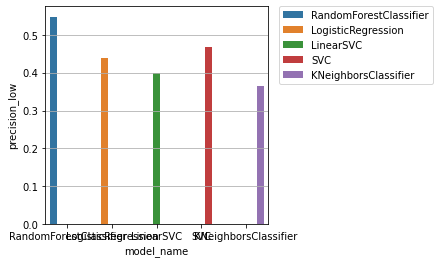

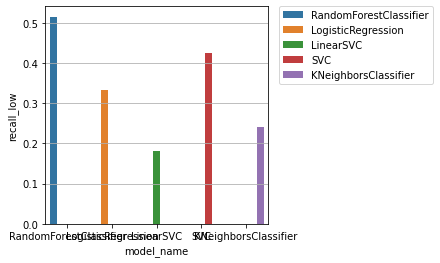

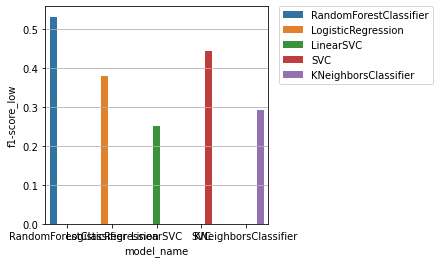

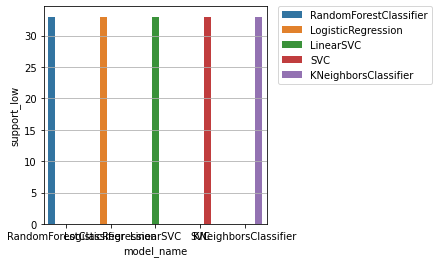

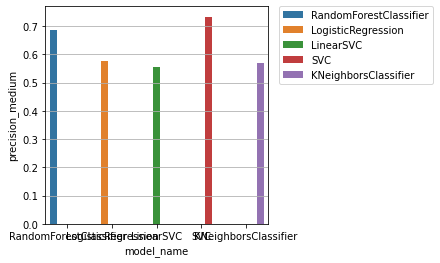

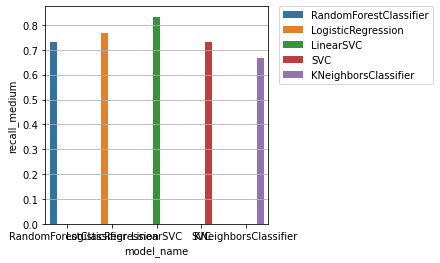

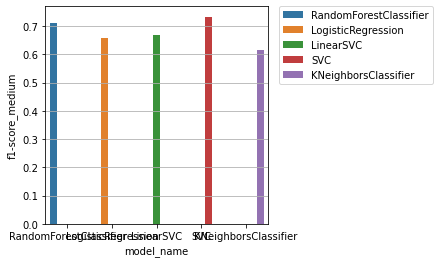

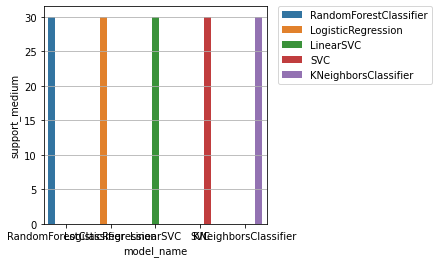

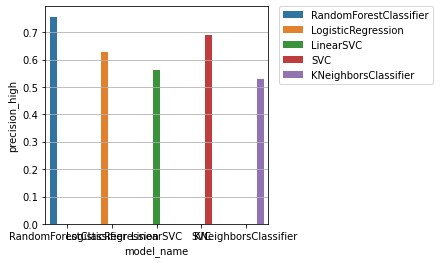

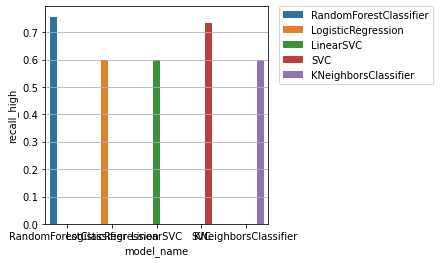

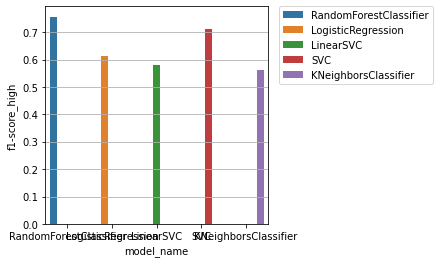

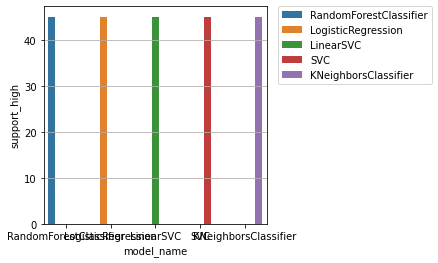

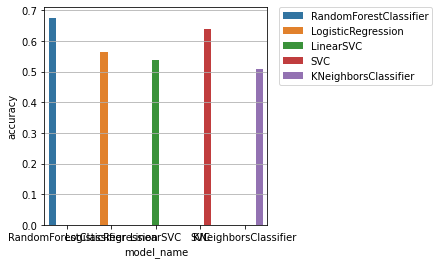

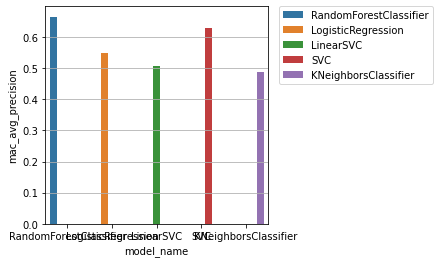

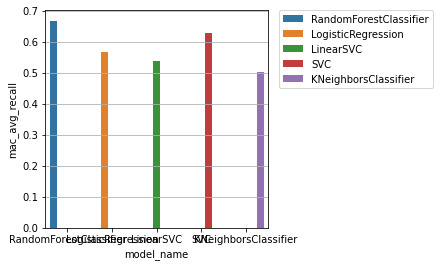

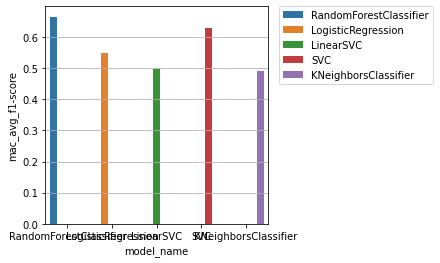

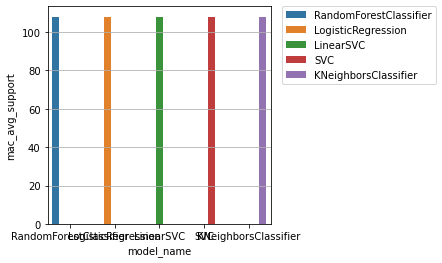

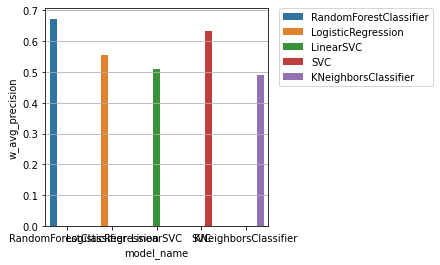

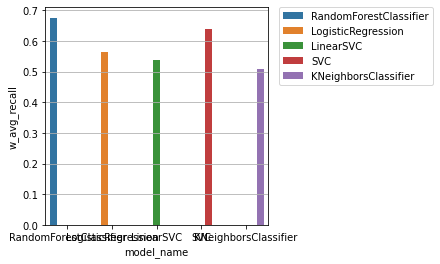

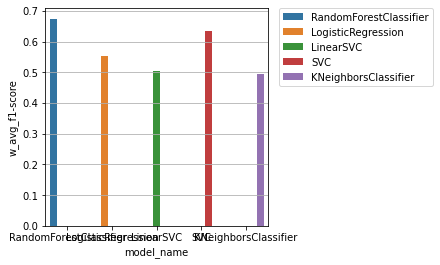

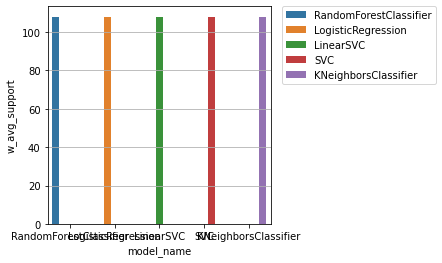

In [19]:
benchmarks = models_report_under.columns[1:]
for ind,benchmark in enumerate(benchmarks):
    fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))
    fig.patch.set_facecolor('white')
    sns.barplot(data = models_report_under,x='model_name',y=f'{benchmark}', hue='model_name', ax = ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(b=True, which='both', axis='y')
    # plt.savefig(f'plots/{benchmark}_by_quality_label.png')

# Comparing models with random SMOTE and StandardScaler

In [20]:
models_report_SMOTE = create_models_comparison(StandardScaler(),models,models_names, sampler = SMOTE(random_state = 42))
models_report_SMOTE

/usr/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


model_name  precision_low  recall_low  f1-score_low  \
0  RandomForestClassifier          0.859       0.773         0.814   
1      LogisticRegression          0.496       0.348         0.409   
2               LinearSVC          0.463       0.172         0.250   
3                     SVC          0.720       0.504         0.593   
4    KNeighborsClassifier          0.510       0.164         0.248   

   support_low  precision_medium  recall_medium  f1-score_medium  \
0          647             0.827          0.866            0.846   
1          647             0.633          0.738            0.682   
2          647             0.598          0.808            0.687   
3          647             0.728          0.795            0.760   
4          647             0.592          0.703            0.643   

   support_medium  precision_high  recall_high  f1-score_high  support_high  \
0             595           0.931        0.988          0.959           605   
1             595           0.630        0.729          0.676           605   
2             595           0.600        0.795          0.684           605   
3             595           0.761        0.936          0.839           605   
4             595           0.548        0.845          0.664           605   

   accuracy  mac_avg_precision  mac_avg_recall  mac_avg_f1-score  \
0     0.873              0.872           0.876             0.873   
1     0.598              0.586           0.605             0.589   
2     0.581              0.553           0.592             0.540   
3     0.739              0.736           0.745             0.731   
4     0.560              0.550           0.570             0.518   

   mac_avg_support  w_avg_precision  w_avg_recall  w_avg_f1-score  \
0             1847            0.872         0.873           0.872   
1             1847            0.584         0.598           0.584   
2             1847            0.551         0.581           0.533   
3             1847            0.736         0.739           0.727   
4             1847            0.549         0.560           0.512   

   w_avg_support  
0           1847  
1           1847  
2           1847  
3           1847  
4           1847

<ipython-input-21-19da467d0bf2>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))


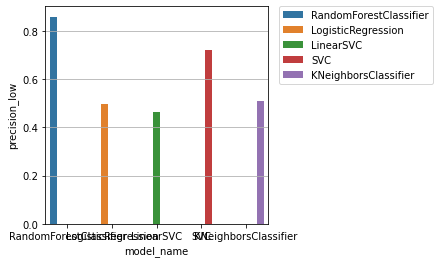

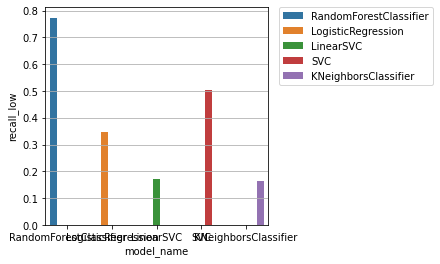

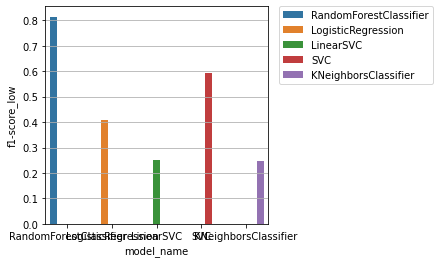

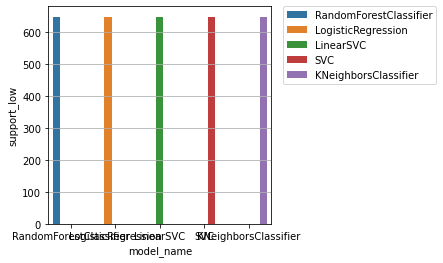

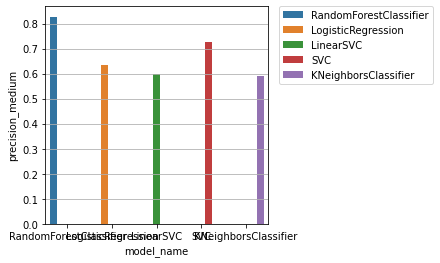

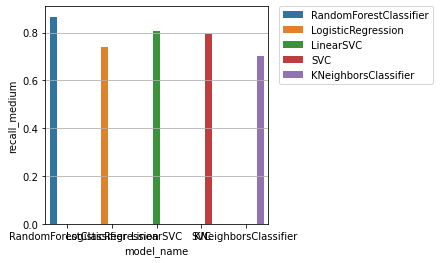

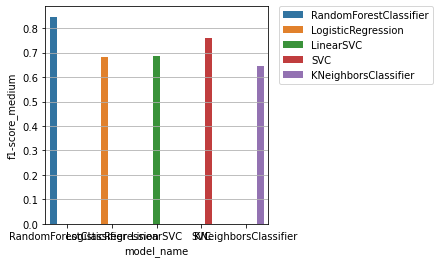

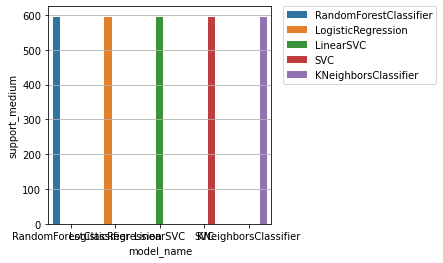

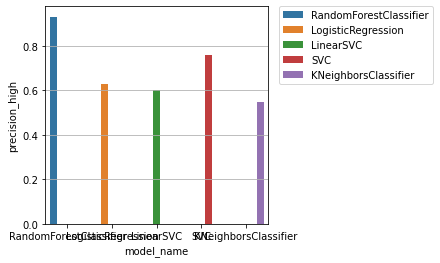

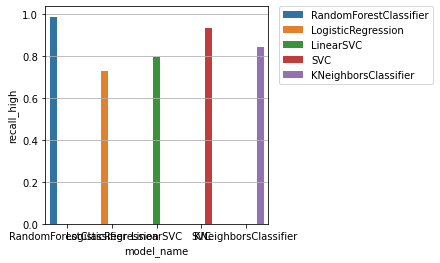

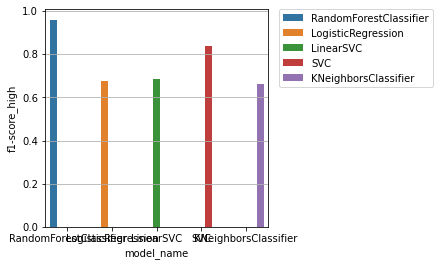

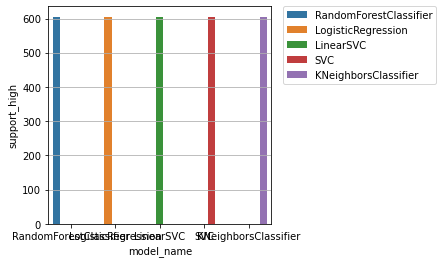

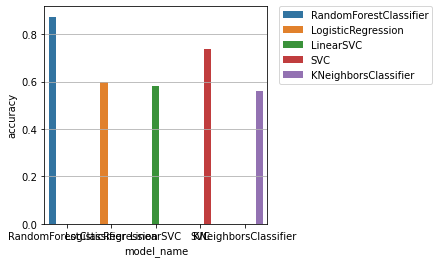

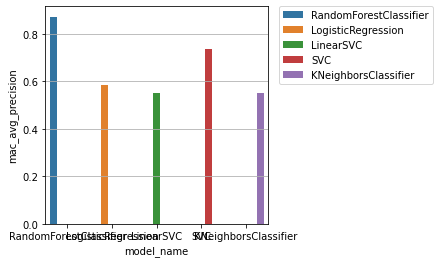

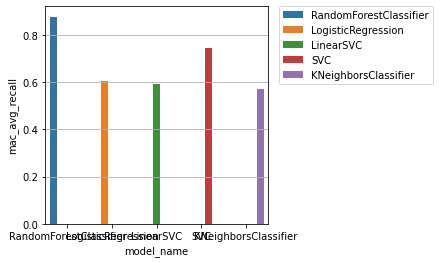

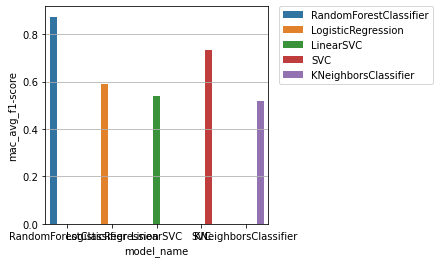

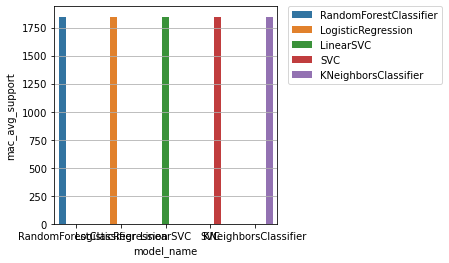

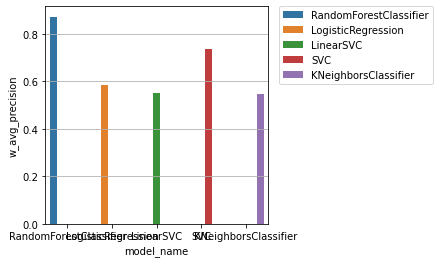

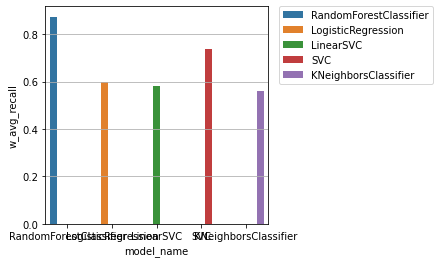

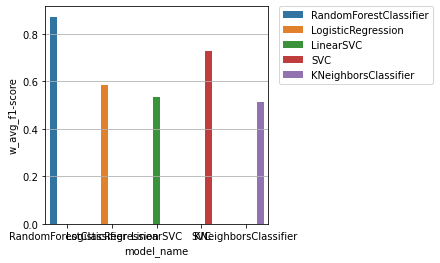

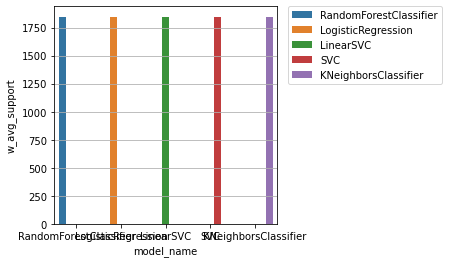

In [21]:

benchmarks = models_report_SMOTE.columns[1:]
for ind,benchmark in enumerate(benchmarks):
    fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))
    fig.patch.set_facecolor('white')
    sns.barplot(data = models_report_SMOTE,x='model_name',y=f'{benchmark}', hue='model_name', ax = ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(b=True, which='both', axis='y')
    # plt.savefig(f'plots/{benchmark}_by_quality_label.png')

# Comparing models using Robust scaler without resampling

In [22]:
from sklearn.preprocessing import RobustScaler
models_report_robscale = create_models_comparison(RobustScaler(),models,models_names)
models_report_robscale

/usr/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sam

model_name  precision_low  recall_low  f1-score_low  \
0  RandomForestClassifier          0.832       0.897         0.864   
1      LogisticRegression          0.733       0.867         0.794   
2               LinearSVC          0.731       0.877         0.797   
3                     SVC          0.758       0.859         0.805   
4    KNeighborsClassifier          0.737       0.747         0.742   

   support_low  precision_medium  recall_medium  f1-score_medium  \
0          624             0.777          0.707            0.741   
1          624             0.656          0.492            0.562   
2          624             0.668          0.483            0.561   
3          624             0.678          0.576            0.623   
4          624             0.556          0.573            0.564   

   support_medium  precision_high  recall_high  f1-score_high  support_high  \
0             321           1.000        0.429          0.600            35   
1             321           0.000        0.000          0.000            35   
2             321           0.000        0.000          0.000            35   
3             321           0.000        0.000          0.000            35   
4             321           0.176        0.086          0.115            35   

   accuracy  mac_avg_precision  mac_avg_recall  mac_avg_f1-score  \
0     0.818              0.870           0.678             0.735   
1     0.713              0.463           0.453             0.452   
2     0.716              0.466           0.453             0.453   
3     0.736              0.479           0.478             0.476   
4     0.666              0.490           0.469             0.474   

   mac_avg_support  w_avg_precision  w_avg_recall  w_avg_f1-score  \
0              980            0.820         0.818           0.814   
1              980            0.682         0.713           0.690   
2              980            0.684         0.716           0.691   
3              980            0.705         0.736           0.717   
4              980            0.658         0.666           0.661   

   w_avg_support  
0            980  
1            980  
2            980  
3            980  
4            980

<ipython-input-23-4eec8cad54ba>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))


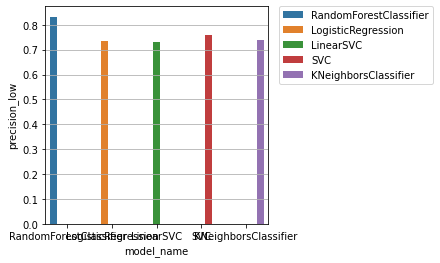

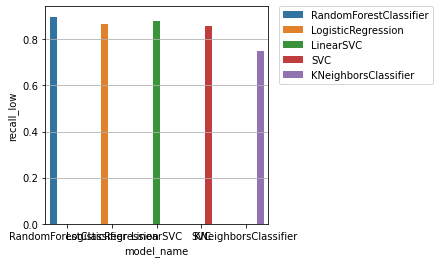

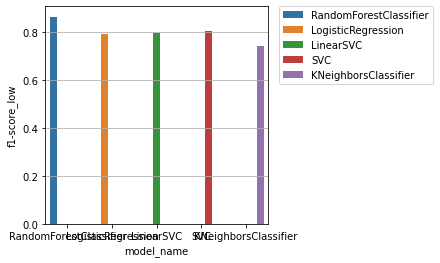

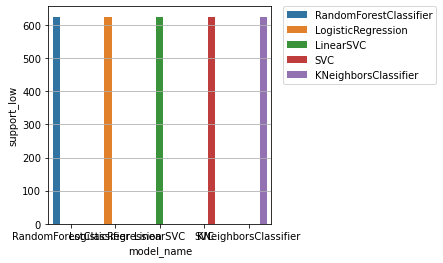

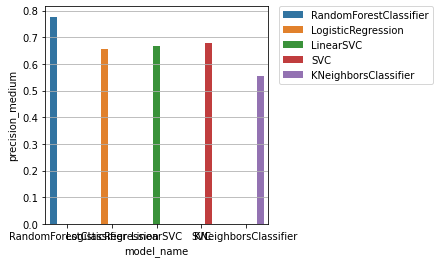

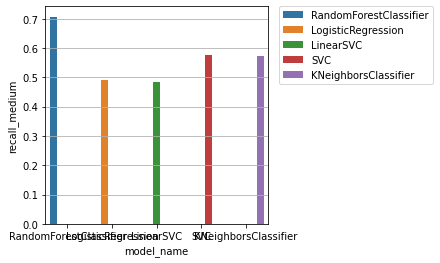

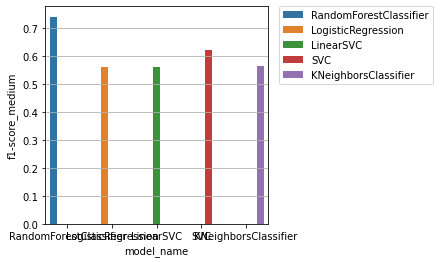

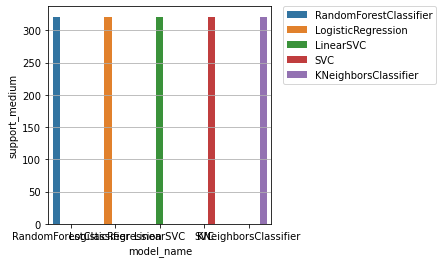

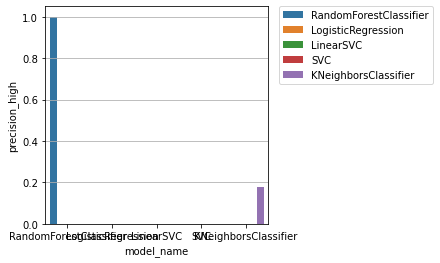

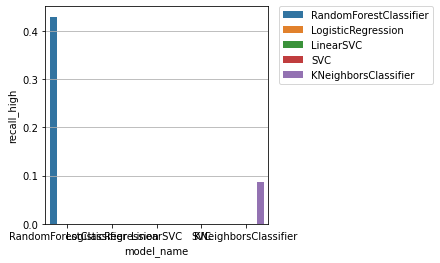

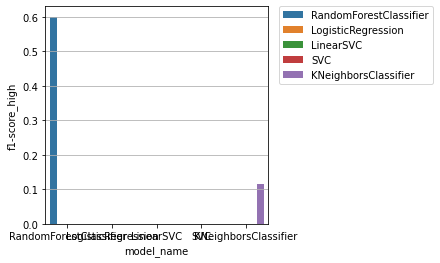

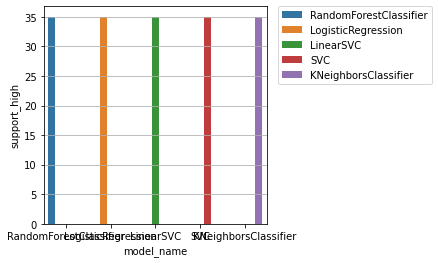

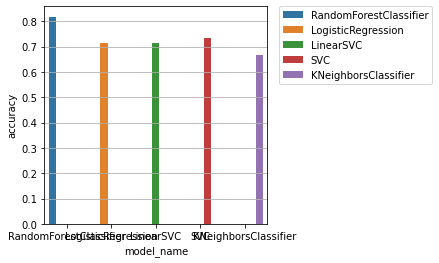

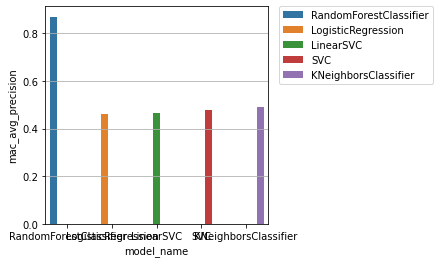

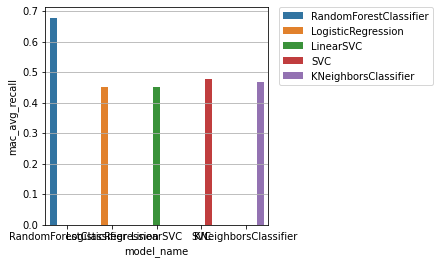

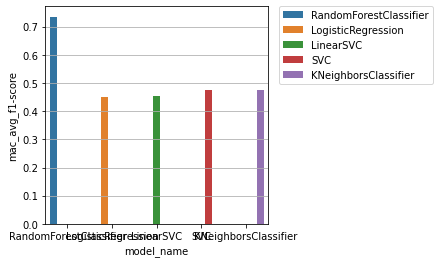

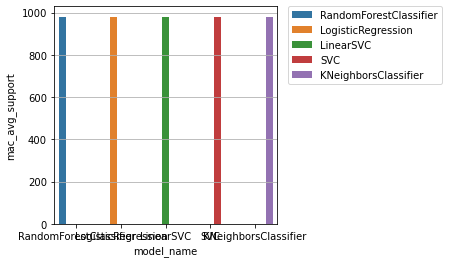

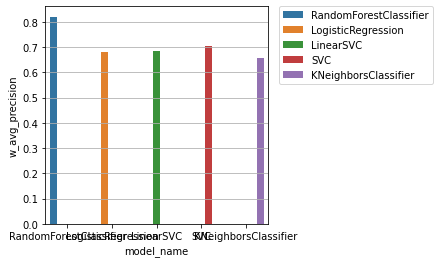

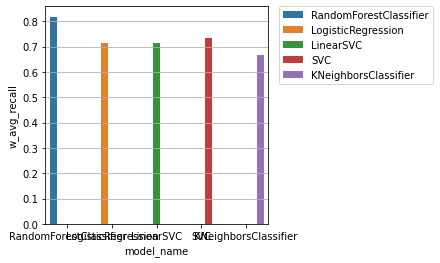

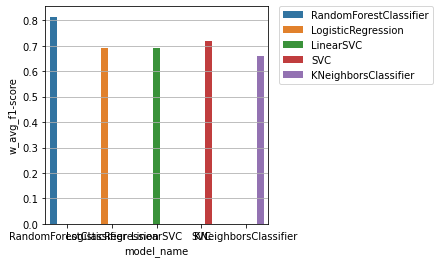

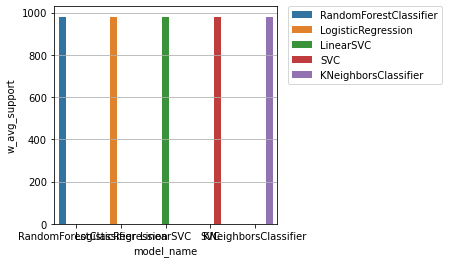

In [23]:

benchmarks = models_report_robscale.columns[1:]
for ind,benchmark in enumerate(benchmarks):
    fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))
    fig.patch.set_facecolor('white')
    sns.barplot(data = models_report_robscale,x='model_name',y=f'{benchmark}', hue='model_name', ax = ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(b=True, which='both', axis='y')
    # plt.savefig(f'plots/{benchmark}_by_quality_label.png')

# Comparing models using robust scaler with SMOTE

In [24]:
models_report_robSMOTE = create_models_comparison(RobustScaler(),models,models_names, sampler = SMOTE(random_state=42))
models_report_robSMOTE


/usr/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


model_name  precision_low  recall_low  f1-score_low  \
0  RandomForestClassifier          0.859       0.784         0.820   
1      LogisticRegression          0.494       0.345         0.406   
2               LinearSVC          0.467       0.175         0.254   
3                     SVC          0.714       0.526         0.606   
4    KNeighborsClassifier          0.510       0.164         0.248   

   support_low  precision_medium  recall_medium  f1-score_medium  \
0          647             0.831          0.869            0.850   
1          647             0.633          0.738            0.681   
2          647             0.597          0.805            0.686   
3          647             0.725          0.780            0.751   
4          647             0.592          0.703            0.643   

   support_medium  precision_high  recall_high  f1-score_high  support_high  \
0             595           0.937        0.983          0.960           605   
1             595           0.628        0.729          0.675           605   
2             595           0.601        0.798          0.686           605   
3             595           0.776        0.937          0.849           605   
4             595           0.548        0.845          0.664           605   

   accuracy  mac_avg_precision  mac_avg_recall  mac_avg_f1-score  \
0     0.877              0.876           0.879             0.876   
1     0.597              0.585           0.604             0.587   
2     0.582              0.555           0.593             0.542   
3     0.742              0.738           0.748             0.735   
4     0.560              0.550           0.570             0.518   

   mac_avg_support  w_avg_precision  w_avg_recall  w_avg_f1-score  \
0             1847            0.876         0.877           0.875   
1             1847            0.583         0.597           0.583   
2             1847            0.553         0.582           0.535   
3             1847            0.738         0.742           0.732   
4             1847            0.549         0.560           0.512   

   w_avg_support  
0           1847  
1           1847  
2           1847  
3           1847  
4           1847

<ipython-input-25-dff7b36f945f>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))


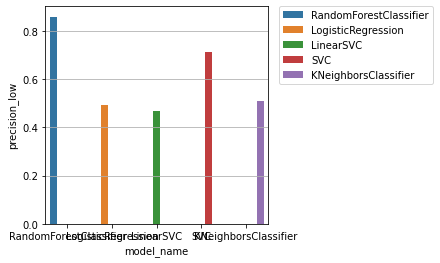

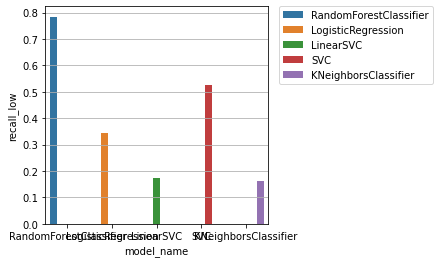

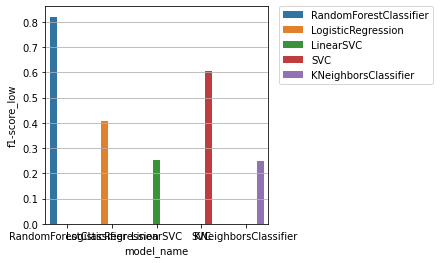

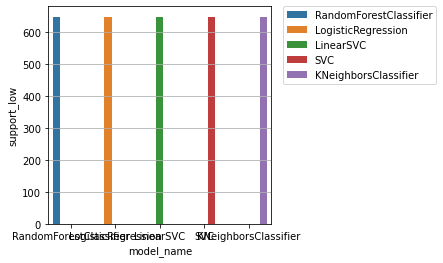

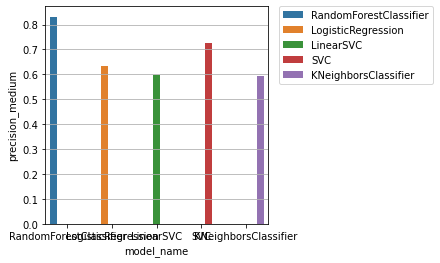

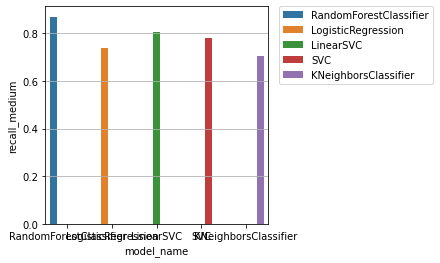

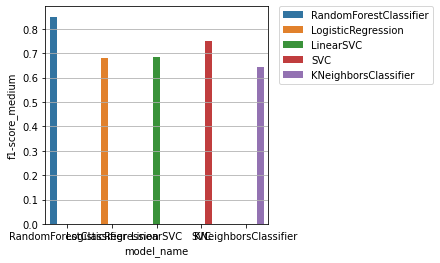

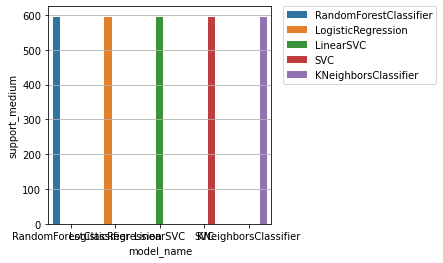

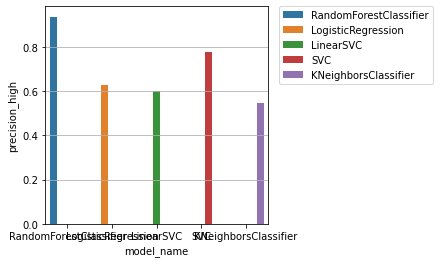

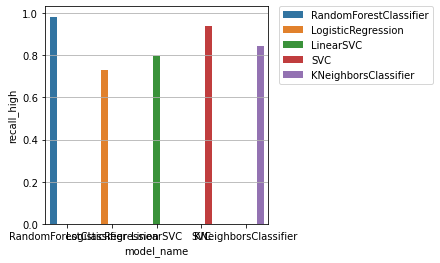

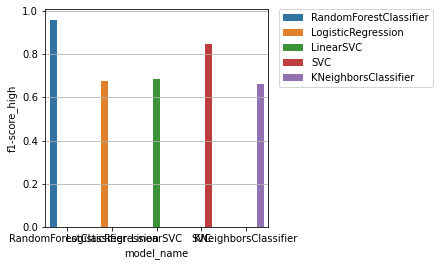

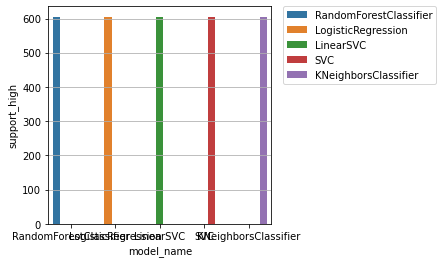

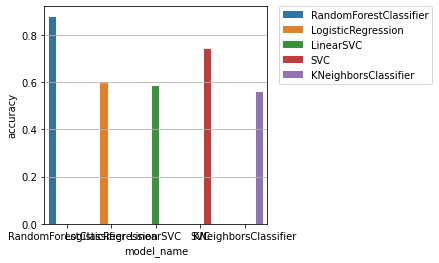

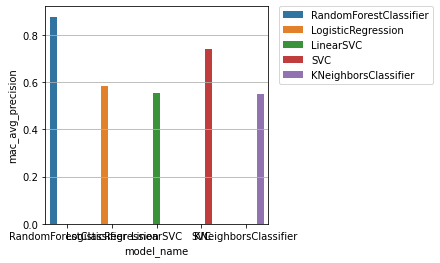

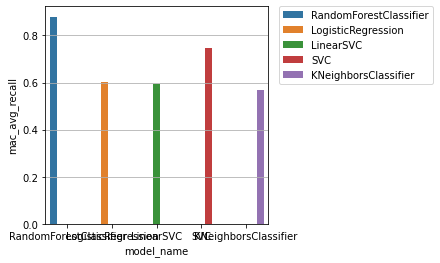

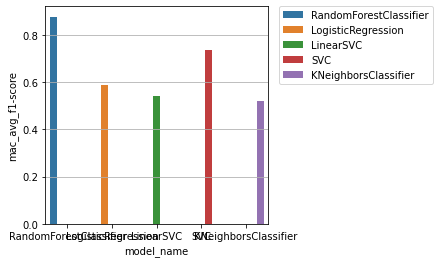

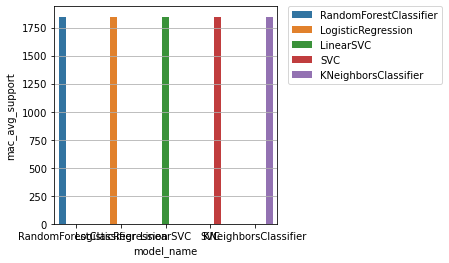

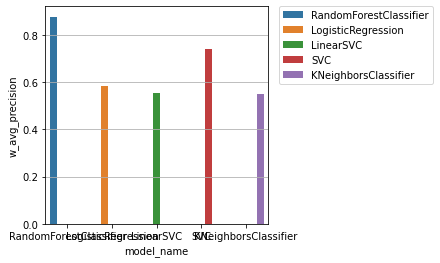

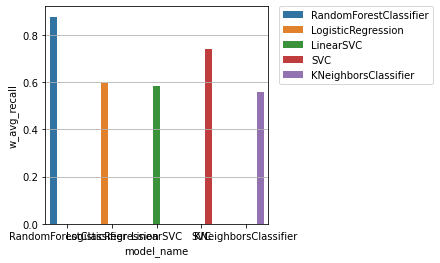

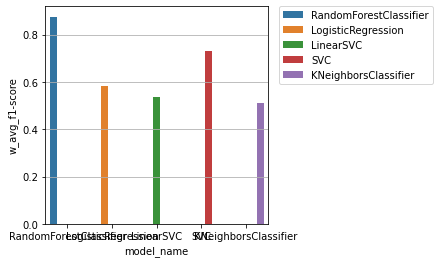

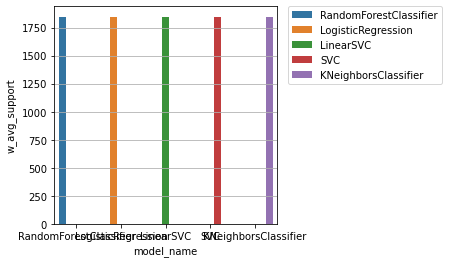

In [25]:
benchmarks = models_report_robSMOTE.columns[1:]
for ind,benchmark in enumerate(benchmarks):
    fig, ax = plt.subplots(nrows=1, ncols = 1,figsize = (4,4))
    fig.patch.set_facecolor('white')
    sns.barplot(data = models_report_robSMOTE,x='model_name',y=f'{benchmark}', hue='model_name', ax = ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(b=True, which='both', axis='y')
    # plt.savefig(f'plots/{benchmark}_by_quality_label.png')

In [26]:
scales = {'StandardScaler':'StnSc','MinMaxScaler':'MinMax','RobustScaler':'RobSc'}
samplers = {'RandomUnderSampler':'RanUnd', 'SMOTE':'SMOTE','None':'None'}
models_report_StnSc['scale'] = 'StandardScaler'
models_report_StnSc['sampler'] = 'None'
display(models_report_StnSc.scale.unique()[0])
models_report_StnSc['new_name'] = models_report_StnSc.model_name.apply(lambda x: f'{x} {samplers[models_report_StnSc.sampler.unique()[0]]} {scales[models_report_StnSc.scale.unique()[0]]}')
display(models_report_StnSc)
models_report_StnSc.drop(['scale', 'new_name', 'sampler'],inplace = True, axis = 1)

'StandardScaler'

model_name  precision_low  recall_low  f1-score_low  \
0  RandomForestClassifier          0.841       0.889         0.864   
1      LogisticRegression          0.733       0.867         0.794   
2               LinearSVC          0.730       0.877         0.797   
3                     SVC          0.760       0.867         0.810   
4    KNeighborsClassifier          0.737       0.747         0.742   

   support_low  precision_medium  recall_medium  f1-score_medium  \
0          624             0.779          0.735            0.756   
1          624             0.656          0.492            0.562   
2          624             0.667          0.480            0.558   
3          624             0.690          0.576            0.628   
4          624             0.556          0.573            0.564   

   support_medium  precision_high  recall_high  f1-score_high  ...  accuracy  \
0             321           0.824        0.400          0.538  ...     0.821   
1             321           0.000        0.000          0.000  ...     0.713   
2             321           0.000        0.000          0.000  ...     0.715   
3             321           0.000        0.000          0.000  ...     0.741   
4             321           0.176        0.086          0.115  ...     0.666   

   mac_avg_precision  mac_avg_recall  mac_avg_f1-score  mac_avg_support  \
0              0.814           0.675             0.720              980   
1              0.463           0.453             0.452              980   
2              0.466           0.452             0.452              980   
3              0.483           0.481             0.479              980   
4              0.490           0.469             0.474              980   

   w_avg_precision  w_avg_recall  w_avg_f1-score  w_avg_support  \
0            0.820         0.821           0.817            980   
1            0.682         0.713           0.690            980   
2            0.683         0.715           0.690            980   
3            0.710         0.741           0.721            980   
4            0.658         0.666           0.661            980   

            scale sampler                           new_name  
0  StandardScaler    None  RandomForestClassifier None StnSc  
1  StandardScaler    None      LogisticRegression None StnSc  
2  StandardScaler    None               LinearSVC None StnSc  
3  StandardScaler    None                     SVC None StnSc  
4  StandardScaler    None    KNeighborsClassifier None StnSc  

[5 rows x 25 columns]

In [27]:
scales = {'StandardScaler':'StnSc','MinMaxScaler':'MinMax','RobustScaler':'RobSc'}
samplers = {'RandomUnderSampler':'RanUnd', 'SMOTE':'SMOTE','None':'None'}
models_report_StnSc['scale'] = 'StandardScaler'
models_report_StnSc['sampler'] = 'None'
models_report_under['sampler'] = 'RandomUnderSampler'
models_report_under['scale'] = 'MinMaxScaler'
models_report_SMOTE['scale'] = 'StandardScaler'
models_report_SMOTE['sampler'] = 'SMOTE'
models_report_robscale['scale'] = 'RobustScaler'
models_report_robscale['sampler'] = 'None'
models_report_robSMOTE['scale'] = 'RobustScaler'
models_report_robSMOTE['sampler'] = 'SMOTE'
model_reports = [
    models_report_StnSc,
    models_report_under,
    models_report_SMOTE,
    models_report_robscale,
    models_report_robSMOTE]
for model in model_reports:
    model.model_name = model.model_name.apply(lambda x: f'{x} {samplers[model.sampler.unique()[0]]} {scales[model.scale.unique()[0]]}')
df_model_reports_combined = models_report_StnSc.append([models_report_under,
    models_report_SMOTE,
    models_report_robscale,
    models_report_robSMOTE])

In [28]:
df_model_reports_combined.sort_values(['accuracy'], ascending = False).head(5)

model_name  precision_low  recall_low  \
0  RandomForestClassifier SMOTE RobSc          0.859       0.784   
0  RandomForestClassifier SMOTE StnSc          0.859       0.773   
0   RandomForestClassifier None StnSc          0.841       0.889   
0   RandomForestClassifier None RobSc          0.832       0.897   
3                     SVC SMOTE RobSc          0.714       0.526   

   f1-score_low  support_low  precision_medium  recall_medium  \
0         0.820          647             0.831          0.869   
0         0.814          647             0.827          0.866   
0         0.864          624             0.779          0.735   
0         0.864          624             0.777          0.707   
3         0.606          647             0.725          0.780   

   f1-score_medium  support_medium  precision_high  recall_high  \
0            0.850             595           0.937        0.983   
0            0.846             595           0.931        0.988   
0            0.756             321           0.824        0.400   
0            0.741             321           1.000        0.429   
3            0.751             595           0.776        0.937   

   f1-score_high  support_high  accuracy  mac_avg_precision  mac_avg_recall  \
0          0.960           605     0.877              0.876           0.879   
0          0.959           605     0.873              0.872           0.876   
0          0.538            35     0.821              0.814           0.675   
0          0.600            35     0.818              0.870           0.678   
3          0.849           605     0.742              0.738           0.748   

   mac_avg_f1-score  mac_avg_support  w_avg_precision  w_avg_recall  \
0             0.876             1847            0.876         0.877   
0             0.873             1847            0.872         0.873   
0             0.720              980            0.820         0.821   
0             0.735              980            0.820         0.818   
3             0.735             1847            0.738         0.742   

   w_avg_f1-score  w_avg_support           scale sampler  
0           0.875           1847    RobustScaler   SMOTE  
0           0.872           1847  StandardScaler   SMOTE  
0           0.817            980  StandardScaler    None  
0           0.814            980    RobustScaler    None  
3           0.732           1847    RobustScaler   SMOTE

# summary from models comparison:
* both standard scaling and robust (median-IQR) scaling are biased against quality_label high due to small number of data points (18 high compared to 744 low and 834 medium)
* Undersampling and MinMax scaler are biased in favor of label quality high, perhaps due to immense data loss (11 data points in support in minmax in comparison to 320 data points in suport in standard scaling without resampling )
* random forest classifier model achieved highet accuracy and balanced f1 and precision across labels both with standardscaler and robust scaler
### next step: comparing the results of random forest classifier with SMOTE scaling of standard scaler against robust scaler:

In [29]:
rfc_ss_df = models_report_SMOTE[models_report_SMOTE.model_name == 'RandomForestClassifier SMOTE StnSc']
rfc_rs_df = models_report_robSMOTE[models_report_robSMOTE.model_name == 'RandomForestClassifier SMOTE RobSc']
rfc_ss_df['scaler'] = 'StandardScaler'
rfc_rs_df['scaler'] = 'RobustScaler'
rfc_df = rfc_ss_df.append(rfc_rs_df)
rfc_df.drop('model_name',axis = 1, inplace = True)

<ipython-input-29-12771a19b5ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfc_ss_df['scaler'] = 'StandardScaler'
<ipython-input-29-12771a19b5ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfc_rs_df['scaler'] = 'RobustScaler'


In [30]:
models_report_SMOTE[models_report_SMOTE.model_name == 'RandomForestClassifier SMOTE StnSc']

model_name  precision_low  recall_low  \
0  RandomForestClassifier SMOTE StnSc          0.859       0.773   

   f1-score_low  support_low  precision_medium  recall_medium  \
0         0.814          647             0.827          0.866   

   f1-score_medium  support_medium  precision_high  recall_high  \
0            0.846             595           0.931        0.988   

   f1-score_high  support_high  accuracy  mac_avg_precision  mac_avg_recall  \
0          0.959           605     0.873              0.872           0.876   

   mac_avg_f1-score  mac_avg_support  w_avg_precision  w_avg_recall  \
0             0.873             1847            0.872         0.873   

   w_avg_f1-score  w_avg_support           scale sampler  
0           0.872           1847  StandardScaler   SMOTE

In [31]:
rfc_df
rfc_df.head()

precision_low  recall_low  f1-score_low  support_low  precision_medium  \
0          0.859       0.773         0.814          647             0.827   
0          0.859       0.784         0.820          647             0.831   

   recall_medium  f1-score_medium  support_medium  precision_high  \
0          0.866            0.846             595           0.931   
0          0.869            0.850             595           0.937   

   recall_high  f1-score_high  support_high  accuracy  mac_avg_precision  \
0        0.988          0.959           605     0.873              0.872   
0        0.983          0.960           605     0.877              0.876   

   mac_avg_recall  mac_avg_f1-score  mac_avg_support  w_avg_precision  \
0           0.876             0.873             1847            0.872   
0           0.879             0.876             1847            0.876   

   w_avg_recall  w_avg_f1-score  w_avg_support           scale sampler  \
0         0.873           0.872           1847  StandardScaler   SMOTE   
0         0.877           0.875           1847    RobustScaler   SMOTE   

           scaler  
0  StandardScaler  
0    RobustScaler

In [32]:
ss_precision = rfc_ss_df.drop(['model_name', 'recall_low', 'f1-score_low',
       'support_low', 'recall_medium', 'f1-score_medium',
       'support_medium', 'recall_high', 'f1-score_high',
       'support_high', 'accuracy', 'mac_avg_precision', 'mac_avg_recall',
       'mac_avg_f1-score', 'mac_avg_support', 'w_avg_precision',
       'w_avg_recall', 'w_avg_f1-score', 'w_avg_support', 'scaler','sampler','scale'],axis = 1,inplace = False).to_numpy()
ss_recall = rfc_ss_df.drop(['model_name', 'precision_low', 'f1-score_low',
       'support_low', 'precision_medium', 'f1-score_medium',
       'support_medium', 'precision_high', 'f1-score_high',
       'support_high', 'accuracy', 'mac_avg_precision', 'mac_avg_recall',
       'mac_avg_f1-score', 'mac_avg_support', 'w_avg_precision',
       'w_avg_recall', 'w_avg_f1-score', 'w_avg_support', 'scaler','sampler','scale'],axis = 1,inplace = False).to_numpy()
ss_f1 = rfc_ss_df.drop(['model_name', 'precision_low', 'recall_low',
       'support_low', 'precision_medium', 'recall_medium',
       'support_medium', 'precision_high', 'recall_high',
       'support_high', 'accuracy', 'mac_avg_precision', 'mac_avg_recall',
       'mac_avg_f1-score', 'mac_avg_support', 'w_avg_precision',
       'w_avg_recall', 'w_avg_f1-score', 'w_avg_support', 'scaler','sampler','scale'],axis = 1,inplace = False).to_numpy()
rs_precision = rfc_rs_df.drop(['model_name', 'recall_low', 'f1-score_low',
       'support_low', 'recall_medium', 'f1-score_medium',
       'support_medium', 'recall_high', 'f1-score_high',
       'support_high', 'accuracy', 'mac_avg_precision', 'mac_avg_recall',
       'mac_avg_f1-score', 'mac_avg_support', 'w_avg_precision',
       'w_avg_recall', 'w_avg_f1-score', 'w_avg_support', 'scaler','sampler','scale'],axis = 1,inplace = False).to_numpy()
rs_recall = rfc_rs_df.drop(['model_name', 'precision_low', 'f1-score_low',
       'support_low', 'precision_medium', 'f1-score_medium',
       'support_medium', 'precision_high', 'f1-score_high',
       'support_high', 'accuracy', 'mac_avg_precision', 'mac_avg_recall',
       'mac_avg_f1-score', 'mac_avg_support', 'w_avg_precision',
       'w_avg_recall', 'w_avg_f1-score', 'w_avg_support', 'scaler','sampler','scale'],axis = 1,inplace = False).to_numpy()
rs_f1 = rfc_rs_df.drop(['model_name', 'precision_low', 'recall_low',
       'support_low', 'precision_medium', 'recall_medium',
       'support_medium', 'precision_high', 'recall_high',
       'support_high', 'accuracy', 'mac_avg_precision', 'mac_avg_recall',
       'mac_avg_f1-score', 'mac_avg_support', 'w_avg_precision',
       'w_avg_recall', 'w_avg_f1-score', 'w_avg_support', 'scaler','sampler','scale'],axis = 1,inplace = False).to_numpy()

In [33]:
ss_precision

array([[0.859, 0.827, 0.931]])

In [34]:
data = {'Scaler':['StandardScaler','RobustScaler'],
        'std_Precision':[np.std(ss_precision),np.std(rs_precision)],
        'std_Recall':[np.std(ss_recall),np.std(rs_recall)],
        'std_f1-score':[np.std(ss_f1),np.std(rs_f1)]}
std_df = pd.DataFrame.from_dict(data)
std_df

Scaler  std_Precision  std_Recall  std_f1-score
0  StandardScaler       0.043492    0.088039      0.062199
1    RobustScaler       0.044850    0.081528      0.060185

* Standard sclaer has lower deviation with every parameter.
* Therefore, the selected model for prediction is Random Forest classifier, with SMOTE sampling and standard scaler
* next, The model is to be optimized with the aid of GridsearchCV

In [35]:
X=df.drop(['quality','quality_label'],axis =1,inplace = False).to_numpy()
y=df['quality_label'].to_numpy()
smote = SMOTE()
stan_scaler = StandardScaler()
X_resamp, y_resamp = smote.fit_resample(X,y)
X_scaled = stan_scaler.fit_transform(X_resamp)
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y_resamp,test_size = 0.2, random_state = 42)

In [36]:
## Using Cohen's Kappa to select the optimal parameters for the classifier

In [37]:
from sklearn.metrics import cohen_kappa_score, make_scorer
cohen_kappa = make_scorer(cohen_kappa_score)
params_dict={'n_estimators':[50,100,500,1000],'criterion':['gini','entropy'],'class_weight':['balanced','balanced_subsample'],'random_state':[None,42],'max_features':['auto','sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),param_grid=params_dict,scoring=cohen_kappa,cv=10)
clf_rf.fit(X_train,y_train)   
print(clf_rf.best_params_,clf_rf.best_score_)

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 1000, 'random_state': None} 0.8312192361382685


In [53]:
help('shelve')

Help on module shelve:

NAME
    shelve - Manage shelves of pickled objects.

MODULE REFERENCE
    https://docs.python.org/3.9/library/shelve
    
    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

DESCRIPTION
    A "shelf" is a persistent, dictionary-like object.  The difference
    with dbm databases is that the values (not the keys!) in a shelf can
    be essentially arbitrary Python objects -- anything that the "pickle"
    module can handle.  This includes most class instances, recursive data
    types, and objects containing lots of shared sub-objects.  The keys
    are ordinary strings.
    
    To summarize the interface (key is a string, data is an arbitrary
    object):
    
            import shelve
          

In [73]:
import dill

ModuleNotFoundError: No module named 'dill'

In [76]:
import pickle
pickle.dump(white_rf2,open('white_rf.dat','wb'))

              precision    recall  f1-score   support

           2       0.85      0.77      0.80       647
           1       0.82      0.86      0.84       595
           0       0.94      0.99      0.96       605

    accuracy                           0.87      1847
   macro avg       0.87      0.87      0.87      1847
weighted avg       0.87      0.87      0.87      1847



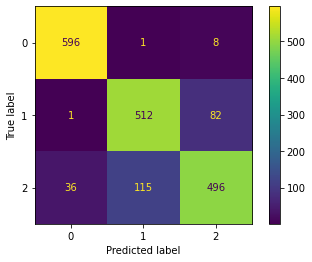

In [38]:
white_rf2 = RandomForestClassifier(class_weight = 'balanced', criterion = 'entropy', max_features = 'auto', n_estimators = 1000)
white_rf2.fit(X_train, y_train)
print(classification_report(y_test, white_rf2.predict(X_test),labels = df.quality_label.unique()))
plot_confusion_matrix(white_rf2,X_test, y_test)
# plt.savefig('plots/white/cohen_confusion_matrix.png')

## Comparing to a dummy classifier

              precision    recall  f1-score   support

           2       0.36      0.35      0.36       647
           1       0.34      0.35      0.34       595
           0       0.34      0.34      0.34       605

    accuracy                           0.35      1847
   macro avg       0.35      0.35      0.35      1847
weighted avg       0.35      0.35      0.35      1847



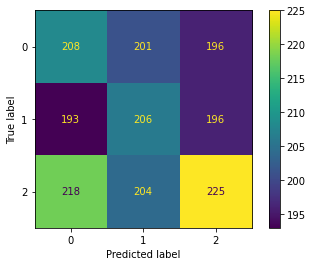

In [39]:
from sklearn.dummy import DummyClassifier

dumc = DummyClassifier(strategy = 'stratified', random_state=42)
dumc.fit(X_train, y_train)
print(classification_report(y_test,dumc.predict(X_test), labels = df.quality_label.unique()))
plot_confusion_matrix(dumc,X_test, y_test)
# plt.savefig('plots/white/dummy_confusion_matrix.png')